In [4]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.dataset as dataset
import numpy as np

from dataset import TestDataset
from model import *

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# Load trained model
net = initialize_model2()
n_features = 512

SAVED_MODEL_PATH = 'checkpoints/vgg11bn_2_4'
net.load_state_dict(torch.load(SAVED_MODEL_PATH))

# Freeze layers
for param in net.parameters():
    param.requires_grad = False
    
# We just want to apply the feature extractor for now
net.classifier = nn.Identity()
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [7]:
# Get dataset
DATA_FILE = 'E:/xplore_data/data/images.h5'
HEALTH_FILE = 'data/dhs_gps.csv'
dimages = TestDataset(DATA_FILE, HEALTH_FILE)
dimagesloader = torch.utils.data.DataLoader(dimages, batch_size=64, shuffle=False, num_workers=0)

In [8]:
# Apply feature extractor to the dataset
n = len(dimages)
extracted_features = torch.zeros(n, n_features+11+1)
i = 0
# Iterate over data.
for x, _, z in dimagesloader:
    x = x.to(device)
    j = i + x.shape[0]
    with torch.set_grad_enabled(False):
        outputs = net(x)
        extracted_features[i:j, :n_features] = torch.squeeze(outputs).cpu()
        extracted_features[i:j, n_features:n_features+11] = z[:, 14:25]
        extracted_features[i:j, n_features+11] = z[:, 3:14].mean(axis=1)
    i += 64

In [9]:
torch.isnan(extracted_features).nonzero()

tensor([], size=(0, 2), dtype=torch.int64)

In [16]:
torch.save(extracted_features, 'data/extracted_features_7_0.pt')

In [10]:
dfeatures = dataset.TensorDataset(extracted_features)

# Randomly split this dataset into train and test.
dtrain, dtest = dataset.random_split(dfeatures, (n - (n//5), n//5))

In [11]:
print(dfeatures.__getitem__(0))
print(dfeatures.__getitem__(0)[0].shape)

(tensor([2.1797e-01, 1.0737e+00, 7.0585e-01, 2.9724e-01, 3.1431e-02, 8.0951e-01,
        1.0346e-01, 8.7693e-01, 1.9167e-01, 7.7996e-01, 3.9781e-01, 3.1805e-01,
        2.0960e-01, 1.4962e+00, 2.1093e-01, 1.0088e+00, 2.4681e-01, 4.4699e-01,
        6.6468e-02, 3.6774e-01, 4.6805e-02, 5.7879e-01, 2.8967e-02, 1.0502e-01,
        1.1837e+00, 9.6163e-01, 1.2119e+00, 6.2948e-01, 1.5520e-01, 7.1309e-01,
        2.3984e-01, 7.8945e-01, 1.4609e+00, 3.3185e-01, 1.4897e-02, 2.1340e-01,
        5.4468e-01, 7.1525e-02, 1.1138e-01, 1.5717e-01, 3.8052e-01, 2.1327e-01,
        1.4530e-01, 1.0995e+00, 5.2661e-02, 2.3954e-02, 3.8900e-01, 2.8578e-01,
        8.1708e-01, 2.6616e-01, 4.0948e-01, 9.8484e-01, 8.7943e-01, 4.9713e-01,
        9.9372e-01, 7.0245e-01, 4.8479e-02, 7.1629e-01, 1.1005e+00, 1.5944e-01,
        3.5356e-01, 2.6040e-01, 8.1439e-01, 6.0648e-02, 1.0158e+00, 8.3280e-01,
        7.1181e-02, 2.8036e-01, 3.2519e-02, 6.1546e-01, 8.0365e-01, 4.1340e-01,
        5.1685e-01, 4.3176e-01, 2.4047e

In [68]:
# Train the predictor model
def train_model(model, dataloader, optimizer, scheduler, num_epochs=4, test_loader=None):
    for epoch in range(num_epochs+1):
        if epoch % 50 == 0:
            print('Epoch {}/{}: '.format(epoch, num_epochs - 1), end='')

        model.train()
        running_loss = 0.0
        criterion = nn.BCEWithLogitsLoss(reduction='none')
#         criterion = nn.MSELoss(reduction='none')

        # Iterate over data.
        for rows in dataloader:
            x = rows[0][:, :n_features].to(device)
#             y = rows[0][:, n_features+3].to(device)
            y = rows[0][:, n_features:n_features+11].to(device)
#             wt = rows[0][:, n_features+11].to(device)
#             wt = wt / wt.sum() * x.shape[0] #give the weights an avg of 1
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(x).squeeze()
#                 print(outputs.shape)
#                 print(y.shape)
#                 loss = torch.sum(criterion(outputs, y).mean(axis=1) * wt)
                loss = torch.mean(criterion(outputs, y))
                loss.backward()
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

            # statistics
            running_loss += loss.item() * x.size(0)

        epoch_loss = running_loss / len(dtrain)
        if epoch % 50 == 0:
            print('Training loss: {:.4f}; '.format(epoch_loss), end='')
        test_loss = 0.0
        
        if test_loader is not None:
            for rows in test_loader:
                x = rows[0][:, :n_features].to(device)
#                 y = rows[0][:, n_features+3].to(device)
                y = rows[0][:, n_features:n_features+11].to(device)
#             wt = rows[0][:, n_features+11].to(device)
#             wt = wt / wt.sum()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(False):
                    outputs = model(x).squeeze()
#                 loss = torch.sum(criterion(outputs, y).mean(axis=1) * wt)
                    loss = torch.mean(criterion(outputs, y))

                # statistics
                test_loss += loss.item() * x.size(0)
        test_loss /= len(dtest)
        if epoch % 50 == 0:
            print('Test loss: {:.4f}'.format(test_loss))

    return model


In [69]:
# Simple neural network to predict healthcare
predictor = nn.Sequential(
#     nn.Linear(n_features, 512),
    nn.Linear(512, 11)
)
predictor.to(device)

Sequential(
  (0): Linear(in_features=512, out_features=11, bias=True)
)

In [70]:
BATCH_SIZE = 889
EPOCHS = 1000

# Data loader
dloader = torch.utils.data.DataLoader(dtrain, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dtestloader = torch.utils.data.DataLoader(dtest, batch_size=512, shuffle=False, num_workers=0)
# Create training optimizer
optimizer = optim.Adam(predictor.parameters(), lr=0.01, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)


In [71]:
predictor = train_model(predictor, dloader, optimizer, scheduler, 
                        num_epochs=EPOCHS, test_loader=dtestloader)

Epoch 0/999: Training loss: 0.7025; Test loss: 1.2143
Epoch 50/999: Training loss: 0.6248; Test loss: 0.6271
Epoch 100/999: Training loss: 0.6120; Test loss: 0.6194
Epoch 150/999: Training loss: 0.6045; Test loss: 0.6152
Epoch 200/999: Training loss: 0.5994; Test loss: 0.6125
Epoch 250/999: Training loss: 0.5960; Test loss: 0.6107
Epoch 300/999: Training loss: 0.5936; Test loss: 0.6094
Epoch 350/999: Training loss: 0.5920; Test loss: 0.6086
Epoch 400/999: Training loss: 0.5908; Test loss: 0.6080
Epoch 450/999: Training loss: 0.5899; Test loss: 0.6075
Epoch 500/999: Training loss: 0.5893; Test loss: 0.6072
Epoch 550/999: Training loss: 0.5888; Test loss: 0.6070
Epoch 600/999: Training loss: 0.5885; Test loss: 0.6068
Epoch 650/999: Training loss: 0.5883; Test loss: 0.6067
Epoch 700/999: Training loss: 0.5881; Test loss: 0.6066
Epoch 750/999: Training loss: 0.5880; Test loss: 0.6065
Epoch 800/999: Training loss: 0.5879; Test loss: 0.6065
Epoch 850/999: Training loss: 0.5878; Test loss: 0.

In [72]:
# Compute r-squared for training and test set
with torch.no_grad():
    split = [dtrain.indices, dtest.indices]
    tensor_inputs = [extracted_features[x, :n_features].to(device) for x in split]
    targets = [extracted_features[x, n_features:n_features+11].numpy() for x in split]
    preds = [torch.sigmoid(predictor(x)).cpu().numpy() for x in tensor_inputs]

In [73]:
print([x.shape for x in targets])
print([x.shape for x in preds])

[(712, 11), (177, 11)]
[(712, 11), (177, 11)]


In [74]:
from sklearn.metrics import r2_score
for i in range(11):
    r2s = [r2_score(y[:, i], pred[:, i]) for y, pred in zip(targets, preds)]
    print('%.4f, %.4f' % tuple(r2s))

0.3794, 0.2437
0.3894, 0.2661
0.3756, 0.2328
0.3690, 0.2420
0.3606, 0.2530
0.3461, 0.2489
0.2821, 0.0920
0.2685, 0.0669
0.1980, 0.0273
0.3551, 0.2460
0.2585, 0.0625


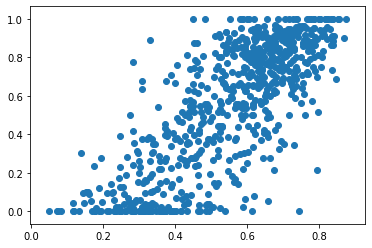

In [59]:
import matplotlib.pyplot as plt
j=3
plt.scatter(preds[0][:, j], targets[0][:,j])
plt.show()

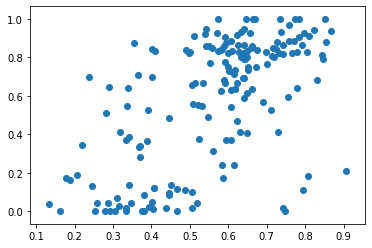

In [60]:
plt.scatter(preds[1][:,j], targets[1][:,j])
plt.show()

In [65]:
from sklearn.linear_model import Ridge

In [113]:
clf = Ridge(alpha=0.01)
arrays = [extracted_features[x, :n_features] for x in split]
targets = [extracted_features[x, n_features:n_features+11].numpy() for x in split]
clf.fit(arrays[0], targets[0])
print(clf.score(arrays[0], targets[0]))
print(clf.score(arrays[1], targets[1]))

0.3167801540702508
-0.04224168877197516


E:\Anaconda\envs\xplore\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
E:\Anaconda\envs\xplore\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  

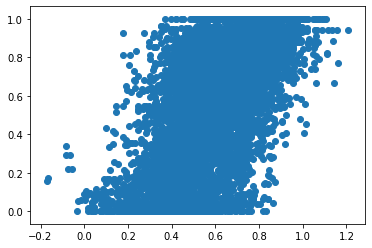

In [114]:
import matplotlib.pyplot as plt
plt.scatter(clf.predict(arrays[0]), targets[0])
plt.show()

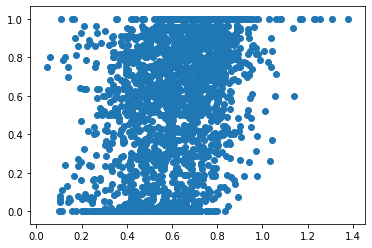

In [115]:

plt.scatter(clf.predict(arrays[1]), targets[1])
plt.show()